# Vectorial Word Representations

## Background
Representing words as dense vectors over a finite-dimensional space was one of the recent breakthroughs in Natural Language Processing. Vectorial representations allow space-efficient, informationally rich storage of words that adequately captures their semantic content and enables numerical computation on them. Word vectors are the standard input representation for machine learning architectures for language processing. Even though new methods for constructing such representations emerge frequently, the original set of published papers remain a de facto point of reference as well as a good starting point. For this assignment, you will be asked to implement a small-scale variant of one such paper, namely [Global Word Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf) ("the GloVe paper").

Much of the code and data pre-processing has already been done for you. Additionally, notes on the paper will appear throughout the notebook to guide you along the code. It is, however, important to read and understand the paper, its terminology and the theory behind it before attempting to go through with the assignment. Some of the tasks will also require addressing the paper directly.

**-------------------------------------------------------------------------------------------------------------**

There are 2 types of tasks in this assignment: 
- coding tasks --- 10 tasks worth 1 point each --- asking you to write code following specifications provided; make sure to <ins>show the code to your teacher after completing every coding task</ins>
- interpretation questions --- 5 questions worth 1 point each --- asking you to interpret the data or the results of the model

You are greatly encouraged to add comments to your code describing what particular lines of code do (in general, a great habit to have in your coding life), as well as self-check regularly by printing your tensors and their shapes making sure they look adequate.

## Corpus Statistics

The paper's proposed model, GloVe, aims to densely represent words in a way that captures the global corpus statistics. 

The construction it encodes is the word __co-occurrence matrix__. A co-occurrence matrix is a simplistic data structure that counts the number of times each word has appeared within the context of every other word. The definition of a context varies; usually, context is implied to be a fixed-length span (that may or may not be allowed to escape sentence boundaries) around a word. 

For instance, in the sentence below and for a context length of 2, the word <span style="color:pink">__Earth__</span> occurs in the context of <span style="color:lightgreen">made</span> (1), <span style="color:lightgreen">on</span> (1), <span style="color:lightgreen">as</span> (1), <span style="color:lightgreen">an</span> (1).

> "He struck most of the friends he had <span style="color:lightgreen">made on</span> <span style="color:pink">__Earth__</span> <span style="color:lightgreen">as an</span> eccentric"

Similarly, the word <span style="color:pink">__friends__</span> occurs in the context of <span style="color:lightgreen">of</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">he</span> (1), <span style="color:lightgreen">had</span> (1).

> "He struck most <span style="color:lightgreen">of the</span> <span style="color:pink">__friends__</span> <span style="color:lightgreen">he had</span> made on Earth as an eccentric"

An alternative definition of a context would be, for instance, the variable-length windows spanned by a full sentence.

Contexts may be summed across sentences or entire corpora; the summed context of <span style="color:pink">he</span> in the example sentence is: <span style="color:lightgreen">struck</span> (1), <span style="color:lightgreen">most</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">friends</span> (1), <span style="color:lightgreen">had</span> (1), <span style="color:lightgreen">made</span> (1).



For the purposes of this assignment, we have prepared a co-occurrence matrix over a minimally processed version of the Harry Potter books.

(A few interpretation tasks in this assignment presuppose some minimal level of familiarity with the Harry Potter books/films. If no one in your group is familiar with Harry Potter, please talk to your teacher)

The pickle file contains three items:
1. `vocab`: a dictionary mapping words to unique ids, containing $N$ unique words
2. `contexts`: a dictionary mapping words to their contexts, where contexts are themselves dicts from words to integers that show the number of co-occurrences between these words.
    E.g. `{"portrait": {"harry": 103, "said": 97, ...}, ...}` meaning that the word "harry" has appeared in the context of the word "portrait" 103 times, etc.
3. `X`: a torch LongTensor ${X}$ of size $N \times N$, where ${X}[i,j]$ denotes the number of times the word with id $j$ has appeared in the context of the word with id $i$

Extremely common or uncommon words (i.e. words with too few or too many global occurrences) have been filtered out for practical reasons.

In [326]:
import pickle
import torch
from torch import FloatTensor, LongTensor
from typing import Dict, Callable, List

In [327]:
with open("output.p", "rb") as f:
    vocab, contexts, X = pickle.load(f)
print(len(vocab))

5359


Let's inspect the summed context of the word 'portrait'.

In [328]:
sorted([(item, value) for item, value in contexts["portrait"].items()], key=lambda x: x[1], reverse=True)

[('harry', 103),
 ('said', 97),
 ('hole', 84),
 ('ron', 49),
 ('hermione', 46),
 ('room', 41),
 ('t', 40),
 ('fat', 39),
 ('lady', 39),
 ('common', 30),
 ('dumbledore', 26),
 ('phineas', 24),
 ('climbed', 22),
 ('just', 19),
 ('swung', 17),
 ('sirius', 17),
 ('professor', 17),
 ('time', 16),
 ('voice', 15),
 ('open', 15),
 ('got', 15),
 ('nigellus', 15),
 ('reached', 14),
 ('like', 14),
 ('came', 14),
 ('little', 14),
 ('gryffindor', 13),
 ('turned', 13),
 ('forward', 12),
 ('don', 12),
 ('long', 12),
 ('place', 12),
 ('wall', 11),
 ('neville', 11),
 ('black', 11),
 ('going', 11),
 ('snape', 11),
 ('hall', 11),
 ('mcgonagall', 11),
 ('corridor', 10),
 ('walked', 10),
 ('away', 10),
 ('ve', 10),
 ('way', 10),
 ('visit', 10),
 ('good', 10),
 ('did', 10),
 ('look', 10),
 ('password', 9),
 ('moment', 9),
 ('know', 9),
 ('sir', 9),
 ('opened', 9),
 ('face', 9),
 ('heard', 9),
 ('come', 8),
 ('gone', 8),
 ('asked', 8),
 ('let', 8),
 ('really', 8),
 ('entrance', 8),
 ('cadogan', 8),
 ('mother

How about the word 'ghost'?

In [304]:
sorted([(item, value) for item, value in contexts["ghost"].items()], key=lambda x: x[1], reverse=True)

[('harry', 52),
 ('said', 36),
 ('nick', 22),
 ('t', 20),
 ('nearly', 20),
 ('headless', 18),
 ('know', 15),
 ('looked', 12),
 ('ron', 10),
 ('saw', 9),
 ('d', 9),
 ('ve', 9),
 ('got', 8),
 ('gryffindor', 8),
 ('years', 7),
 ('bloody', 7),
 ('baron', 7),
 ('wand', 7),
 ('cedric', 7),
 ('dumbledore', 7),
 ('just', 6),
 ('don', 6),
 ('think', 6),
 ('told', 6),
 ('slytherin', 6),
 ('staring', 6),
 ('eyes', 6),
 ('professor', 6),
 ('passed', 6),
 ('like', 6),
 ('hermione', 6),
 ('gray', 6),
 ('ruff', 5),
 ('suddenly', 5),
 ('table', 5),
 ('potter', 5),
 ('giving', 5),
 ('began', 5),
 ('tower', 5),
 ('magic', 5),
 ('binns', 5),
 ('light', 5),
 ('held', 5),
 ('head', 5),
 ('little', 5),
 ('solid', 5),
 ('really', 4),
 ('hufflepuff', 4),
 ('hat', 4),
 ('opposite', 4),
 ('seen', 4),
 ('arm', 4),
 ('need', 4),
 ('sir', 4),
 ('gaunt', 4),
 ('face', 4),
 ('silver', 4),
 ('corridor', 4),
 ('covered', 4),
 ('wide', 4),
 ('oh', 4),
 ('asked', 4),
 ('away', 4),
 ('myrtle', 4),
 ('hair', 4),
 ('thing'

In [329]:
i = vocab['asked']
i

4623

The co-occurrence matrix of a very large corpus should give a meaningful summary of how a word is used in general. A single row of that matrix is already a __word vector__ of size $N$. However such vectors are extremely sparse, and for large corpora the size of $N$ will become unwieldy. We will follow along the paper in designing an algorithm that can compress the word vectors while retaining most of their informational content. 

<div class="alert alert-block alert-info">
<b>Note:</b>
For the resulting vectors to actually be informative, the source corpus should have a size of at least a few billion words; on the contrary, our corpus enumerates merely a million words, so we can't expect our results to be as great.
</div>

### Sparsity and Stability

Our matrix $X$ is very sparse; most of its elements are zero.

**Coding 1.1**: Find what the ratio of non-zero elements is.

_Hint_: The function `non_zero_ratio` should return a `float` rather than a `FloatTensor`. Remember `.item()`.

In [330]:
def non_zero_ratio(sparse_matrix: LongTensor) -> float:
    xnonZero = torch.count_nonzero(sparse_matrix)
    N,M = sparse_matrix.shape
    xallValues = N * M
    ratio = xnonZero/xallValues
    ratio.item()
    print(ratio.item())
    
non_zero_ratio(X)

0.10844852030277252


We will soon need to perform division and find the logarithm of ${X}$. Neither of the two operations are well-defined for $0$. That's why for further processing we want to have a matrix without any zero elements. 

**Coding 1.2**: Change the matrix's datatype to a `torch.float` and add a small constant to it (e.g. $0.1$) to ensure numerical stability while maintaining sparsity.

In [331]:
d  = torch.tensor([[1., 0.], [0., -1.]])
print(torch.count_nonzero(d.T))

tensor(2)


In [332]:
X = X.to(torch.float) + 0.1

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### From co-occurrence counts to probabilities
From the paper: 
> Let the matrix of word-word co-occurrence counts be denoted by $X$, whose entries $X_{ij}$ tabulate the number of times word $j$ occurs in the context of word $i$.  Let $X_i$= $\sum_{k} X_{ik}$ be the number of times any word appears in the context of word $i$. Finally, let $P_{ij} = P(j  | i) =  X_{ij}/X_i$ be the probability that word $j$ appear in the context of word $i$. 

**Coding 2**: Complete the function `to_probabilities` that accepts a co-occurrence matrix and returns the probability matrix $P$. 

_Hint_: Remember broadcasting and `torch.sum()`.

In [333]:
def to_probabilities(count_matrix: FloatTensor) -> FloatTensor:
    total_amout = len(count_matrix)
    sum_ = torch.sum(count_matrix,0, keepdim=False, dtype = float)
    return(count_matrix / sum_.T)
    
P = to_probabilities(X)


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Probing words

From the paper:
> Consider two words $i$ and $j$ that exhibit a particular aspect of interest. The relationship of these words can be examined by studying the ratio of their co-occurrence probabilities with various probe words, $k$.  For words $k$ related to $i$ but not $j$, we expect the ratio $P_{ik}/P_{jk}$ will be large.  Similarly, for words $k$ related to $j$ but not $i$, the ratio should be small. For words $k$ that are either related to both $i$ and $j$, or to neither, the ratio should be close to one.

**Coding 3.1**: Complete the function `query` that accepts two words $w_i$ and $w_j$, a vocab $V$ and a probability matrix ${P}$, maps each word to its corresponding index and returns the probability $P(j  |  i)$.

In [335]:
def query(word_i: str, word_j: str, vocab: Dict[str, int], probability_matrix: FloatTensor) -> float:  
    i = vocab[word_i]
    j = vocab[word_j]
    return(probability_matrix[i][j])


**Coding 3.2**: Then, complete the function `probe` that accepts three words $w_i$, $w_j$ and $w_k$, a vocab $V$ and a probability matrix ${P}$, calls `query` and returns the ratio $P(k |  i) / P(k  |  j)$.

In [336]:
def probe(word_i: str, word_j: str, word_k: str, vocab: Dict[str, int], probability_matrix: FloatTensor) -> float:
    
    Pki = query(word_k, word_i, vocab, probability_matrix)
    Pkj = query(word_k, word_j, vocab, probability_matrix)
    return Pki/Pkj


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

Let's probe a few words and examine whether the authors' claim holds even for our (tiny) corpus. Feel free to add your own word triplets and experiment.

In [337]:
print("tea", "wand", "spell", probe("tea", "wand", "spell", vocab, P))
print("tea", "wand", "cup", probe("tea", "wand", "cup", vocab, P))
print()

print("voldemort", "hagrid", "curse", probe("voldemort", "hagrid", "curse", vocab, P))
print("voldemort", "hagrid", "beast", probe("voldemort", "hagrid", "beast", vocab, P))
print()

print("mcgonagall", "snape", "potions", probe("mcgonagall", "snape", "potions", vocab, P))
print("mcgonagall", "snape", "transfiguration", probe("mcgonagall", "snape", "transfiguration", vocab, P))
print()

print("hedwig", "scabbers", "owl", probe("hedwig", "scabbers", "owl", vocab, P))
print("hedwig", "scabbers", "rat", probe("hedwig", "scabbers", "rat", vocab, P))
print()

print("ron", "hermione", "book", probe("ron", "hermione", "book", vocab, P))
print("ron", "hermione", "red", probe("ron", "hermione", "red", vocab, P))
print()



tea wand spell tensor(0.4226, dtype=torch.float64)
tea wand cup tensor(24.6131, dtype=torch.float64)

voldemort hagrid curse tensor(8.7108, dtype=torch.float64)
voldemort hagrid beast tensor(0.5588, dtype=torch.float64)

mcgonagall snape potions tensor(0.0036, dtype=torch.float64)
mcgonagall snape transfiguration tensor(43.7188, dtype=torch.float64)

hedwig scabbers owl tensor(5.6266, dtype=torch.float64)
hedwig scabbers rat tensor(0.0178, dtype=torch.float64)

ron hermione book tensor(0.6783, dtype=torch.float64)
ron hermione red tensor(2.0383, dtype=torch.float64)



**Interpretation 1**: Give a brief interpretation of the results you got. Do they correspond to your expectations? Why or why not?

*Hint*: When do we expect the ratio value to be high, low or close to 1? Refer to the GloVe paper for guidance.

What would happen if we tried probing out-of-domain words? Use the words that the authors report in the paper as discriminative for "ice" and "steam".

In [338]:
word1 = "ice"
word2 = "steam"
print("ice", "steam", word1, probe("ice", "steam", word1, vocab, P))
print("ice", "steam", word2, probe("ice", "steam", word2, vocab, P))

ice steam ice tensor(0.9024, dtype=torch.float64)
ice steam steam tensor(0.9024, dtype=torch.float64)


**Interpretation 2**: Give an interpretation of the results you got. Do they match what the authors report in the paper? Why or why not?

In [339]:
X

tensor([[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        ...,
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]])

## Dense Vectors

Now, we would like to convert these long sparse vectors into short dense ones. 

The conversion should be such that the probability ratios we inspected earlier may still be reconstructed via some (for now, unknown) operation $F$ on the dense vectors.

To restrict the search space over potential functions, the authors impose a number of constraints they think $F$ should satisfy:
1. > While $F$ could be taken to be a complicated function parameterized by, e.g., a neural network, doing so would obfuscate the linear structure we are trying to capture. $F$ should be dot-product based.
2. > The distinction between a word and a context word is arbitrary and we are free to exchange the two roles. To do so consistently, we must not only exchange $w \leftrightarrow \tilde{w}$ but also $X \leftrightarrow X^T$.
3. > It should be well-defined for all values in $X$.

Given these three constraints, each word $i$ in our vocabulary is represented by four vectors:
1. A vector $w_i \in \mathbb{R}^D$
2. A bias $b_i \in \mathbb{R}$
3. A context vector $\tilde{w}_i \in \mathbb{R}^D$
4. A context bias $\tilde{b}_i \in \mathbb{R}$

and $F: \mathbb{R}^D \times \mathbb{R} \times \mathbb{R}^D \times \mathbb{R} \to \mathbb{R}$ is defined as:

$F(w_i, \tilde{w}_k, b_i, \tilde{b}_k) = w_i^T\tilde{w}_k + b_i + \tilde{b}_k$.

Or equivalently the least squares error $J$ is minimized, where:

$J = \sum_{i,j=1}^{V} f(X_{ij})(w_{i}^T\tilde{w}_j + b_i + \tilde{b}_j - log(X_{ij}))^2$

with $f$ being a weighting function, defined as 

$f: \mathbb{R} \to \mathbb{R} = \begin{cases}
    (x/x_{max})^\alpha, & \text{if $x<x_{max}$}\\
    1, & \text{otherwise}.
  \end{cases}$

### Weighting Function

Let's start with the last part. 

**Coding 4**: Complete the weighting function `weight_fn` which accepts a co-occurrence matrix ${X}$, a maximum value $x_{max}$ and a fractional power $alpha$, and returns the weighted co-occurrence matrix $f({X})$.

Then, compute $\text{X_weighted}$, the matrix ${X}$ after weighting, using the paper's suggested parameters. 

_Hint_: Note that $f$ is defined pointwise, so our weighting function should also be pointwise.

In [395]:
def weight_fn(X: FloatTensor, x_max: int, alpha: float) -> FloatTensor:
    return(torch.where(X<x_max,(X/x_max)**alpha,torch.ones_like(X)))
    

X_weighted = weight_fn(X,100, 0.75)

print(X_weighted)

tensor([[0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        ...,
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056]])


Try to get an understanding of how the weighting affects different co-occurrence values (high and low). Think of some word pairs with high and low co-occurrence and look them up in $X$ and in $\text{X_weighted}$ to get a better idea. 

In [384]:
print(X_weighted)

tensor([[0.5012, 0.5012, 0.5012,  ..., 0.5012, 0.5012, 0.5012],
        [0.5012, 0.5012, 0.5012,  ..., 0.5012, 0.5012, 0.5012],
        [0.5012, 0.5012, 0.5012,  ..., 0.5012, 0.5012, 0.5012],
        ...,
        [0.5012, 0.5012, 0.5012,  ..., 0.5012, 0.5012, 0.5012],
        [0.5012, 0.5012, 0.5012,  ..., 0.5012, 0.5012, 0.5012],
        [0.5012, 0.5012, 0.5012,  ..., 0.5012, 0.5012, 0.5012]])


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Loss Function

Next step is to write the loss function. 

We can write it as a pointwise function, apply it iteratively over each pair of words and then sum the result; that's however extremely inefficient. 

Inspecting the formulation of $J$, it is fairly straight-forward to see that it can be immediately implemented using matrix-matrix operations, as:

$J = \sum_{i,j=1}^{V}f(\mathbf{X})\cdot(W\tilde{W}^T + b + \tilde{b}^T - log(X))^2$,

where $W$, $\tilde{W}$ are the $N \times D$ matrices containing the $D$-dimensional vectors of all our $N$ vocabulary words, and $b$, $\tilde{b}$ are the $N \times 1$ matrices containing the $1$-dimensional biases of our words.

**Coding 5**: Complete `loss_fn`, a function that accepts a weighted co-occurrence matrix $f({X})$, the word vectors and biases $W$, $\tilde{W}$, $b$, $\tilde{b}$ and the co-occurrence matrix ${X}$, and computes $J$. 

In [385]:
aa = torch.ones(1,4)
aa = torch.transpose(aa,0,1)
c = torch.tensor([[ 1, 2, 3],[-1, 1, 4]] , dtype= torch.float)
print(torch.max(c))
print(c)

tensor(4.)
tensor([[ 1.,  2.,  3.],
        [-1.,  1.,  4.]])


In [396]:
def loss_fn(
    X_weighted: FloatTensor, 
    W: FloatTensor, 
    W_context: FloatTensor, 
    B: FloatTensor, 
    B_context: FloatTensor, 
    X: FloatTensor
) -> FloatTensor:
    return torch.sum( X_weighted * ((W @ W_context.T) + (B + B_context.T) - (torch.log(X))**2))


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### GloVe

We have the normalized co-occurrence matrix ${X}$, the weighting function $f$, and the loss function $J$ that implements $F$.

What we need now is a mapping from words (or word ids) to unique, parametric and trainable vectors. 

Torch provides this abstraction in the form of [Embedding layers](https://pytorch.org/docs/stable/nn.html#embedding). Each such layer may be viewed as a stand-alone network that can be optimized using the standard procedure we have already seen. 

We will utilize the `nn.Module` class to contain all our embedding layers and streamline their joint optimization.
The container class will be responsible for a few things:

1. **Coding 6.1**: Wrapping the embedding layers:
    1. A vector embedding that maps words to $w \in \mathbb{R}^D$
    2. A context vector embedding that maps words to $w_c \in \mathbb{R}^D$
    3. A bias embedding that maps words to $b \in \mathbb{R}^1$
    4. A context bias embedding that maps words to $b_c \in \mathbb{R}^1$
2. **Coding 6.2**: Implementing `forward`, a function that accepts a weighted co-occurrence matrix $f(X)$, the co-occurrence matrix $X$, then finds the embeddings of all words and finally calls `loss_fn` as defined above.
3. **Coding 7**: Implementing `get_vectors`, a function that receives no input and produces the word vectors and context word vectors of all words, adds them together and returns the result, in accordance with the paper:
> ...With this in mind, we choose to use the sum $W + \tilde{W}$ as our word vectors.

Complete the network class following the above specifications.  

In [397]:
# an Embedding module containing 10 tensors of size 3
embedding = torch.nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[0,2]])
print(embedding(input))
embedding.weight

tensor([[[ 0.9646, -0.1698, -1.2026],
         [-0.8334,  1.1966,  0.5458]]], grad_fn=<EmbeddingBackward0>)


Parameter containing:
tensor([[ 9.6461e-01, -1.6984e-01, -1.2026e+00],
        [ 1.5473e+00,  3.4739e-01, -6.6663e-01],
        [-8.3339e-01,  1.1966e+00,  5.4584e-01],
        [-5.0849e-01, -9.0397e-01,  1.7192e-01],
        [ 2.0055e-01,  1.1784e+00, -2.1142e-01],
        [-3.3658e-01, -1.0277e+00,  6.9027e-01],
        [-5.6364e-01, -2.3867e+00,  4.6412e-01],
        [-1.2545e+00, -8.1748e-01, -1.2507e-03],
        [-1.2767e+00,  7.0950e-01, -6.2024e-01],
        [ 4.7387e-01,  4.2758e-01, -5.1466e-01]], requires_grad=True)

In [398]:
class GloVe(torch.nn.Module):
    def __init__(self, vocab: Dict[str, int], vector_dim: int=30, device: str="cpu") -> None:
        super(GloVe, self).__init__()
        self.device = device
        self.vocab_len = len(vocab)
        self.w = torch.nn.Embedding(num_embeddings = self.vocab_len, embedding_dim  =vector_dim).to(self.device)
        self.wc = torch.nn.Embedding(num_embeddings = self.vocab_len, embedding_dim  =vector_dim).to(self.device)
        self.b = torch.nn.Embedding(self.vocab_len,1).to(self.device)
        self.bc = torch.nn.Embedding(self.vocab_len, 1).to(self.device)
        
    def forward(self, X_weighted: FloatTensor, X: FloatTensor) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        W = self.w(embedding_input)
        Wc = self.wc(embedding_input)
        b_ = self.b(embedding_input)
        b_c = self.bc(embedding_input)
        return(loss_fn (X_weighted , W, Wc, b_, b_c , X))
        

    def get_vectors(self) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        w_word_vector = self.w(embedding_input)
        Wc_word_vector = self.wc(embedding_input)
        return (w_word_vector + Wc_word_vector)

### Training

Everything is in place; now we may begin optimizing our embedding layers (and in doing so, the vectors they assign). 

**Coding 8.1**: Instantiate the network class you just defined using $D = 30$. Then instantiate an `Adam` optimizer with a learning rate of 0.05 and train your network for 300 epochs.

When writing the training script, remember that your network's forward pass is __already__ computing the loss.

In [399]:
network = GloVe(vocab)
opt =torch.optim.Adam(network.parameters(), lr=0.05)

num_epochs = 50
losses = []
epoches =[]

for i in range(num_epochs):
    loss =  network(X_weighted,X) # loss computation (optionally print it out)
    loss.backward() # back-propagation
    
    opt.step() # gradient computation 
    losses.append(loss)
    opt.zero_grad() # gradient reset

**Coding 8.2**: Plot the losses and examine the learning curve. Is its shape what you would expect it to be?

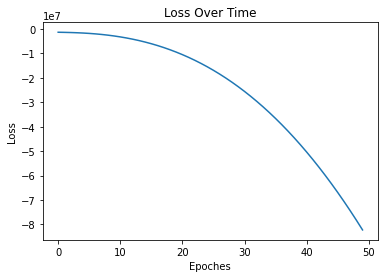

In [400]:
# Your plotting here
import matplotlib.pyplot as plt 
plt.plot( losses)
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.show()


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Validation (Similarity)

Curious to see what this network has learned? Let's perform a simple validation experiment. 

We will check which words the models considers the most similar to other words. To that end, we need a notion of __similarity__. One of the most common measures of similarity in high dimensional vector spaces is the cosine similarity. 

The cosine similarity of two vectors $\vec{a}, \vec{b}$ is given as:
$$sim(\vec{a}, \vec{b}) = \frac{\vec{a}\cdot \vec{b}}{|\vec{a}|_2 \cdot |\vec{b}|_2}$$

where $|\vec{x}|_2$ is the $L_2$-norm of the $\vec{x}$.

The function `similarity` below accepts two words, a vocabulary and the network's output vectors, and computes the similarity between these two words.

In [212]:
def similarity(word_i: str, word_j: str, vocab: Dict[str, int], vectors: FloatTensor) -> float:
    i = vocab[word_i]
    j = vocab[word_j] 
    v_i = vectors[i] / torch.norm(vectors[i], p=2)  # a/|a|
    v_j = vectors[j] / torch.norm(vectors[j], p=2)  # b/|b|
    sim = torch.mm(v_i.view(1, -1), v_j.view(-1, 1)).item()
    return sim

Let's check out some examples. Consider the word pairs below and, optionally, add your own word pairs:

In [213]:
word_vectors = network.get_vectors().detach()

for pair in [
    ("cruciatus", "imperius"), 
    ("avada", "kedavra"), 
    ("hogwarts", "school"), 
    ("goblin", "hagrid"), 
    ("giant", "hagrid"),
]:
    
    print("Similarity between '{}' and '{}' is: {}".
          format(pair[0], pair[1], similarity(pair[0], pair[1], vocab, word_vectors)))

Similarity between 'cruciatus' and 'imperius' is: 0.14339786767959595
Similarity between 'avada' and 'kedavra' is: -0.09358502924442291
Similarity between 'hogwarts' and 'school' is: -0.15029765665531158
Similarity between 'goblin' and 'hagrid' is: -0.14541365206241608
Similarity between 'giant' and 'hagrid' is: -0.20085063576698303


**Interpretation 3**: Give a brief interpretation of the results. Do the scores correspond well to your perceived similarity of these word pairs?

In [414]:
print(word_vectors[0])
print(vocab[])

tensor([-1.5767, -0.6242, -0.4529, -0.5728, -0.1517, -1.2727, -2.6586,  1.5638,
        -1.3697,  1.0767, -3.0725,  0.8994,  0.4655, -0.1754,  0.3075, -1.0141,
         1.3937,  1.0291, -0.0165,  0.2722,  1.2506, -1.4158,  0.4231, -1.2927,
        -0.8927, -1.9439,  0.0937, -0.0412, -1.0290, -1.2696])


To obtain the similarities of one word against all other words in the corpus, we may rewrite the above equation as:
$$sim(\vec{w}, \mathbf{C}) = \frac{\vec{w}\cdot \mathbf{C}}{|\vec{w}|_2 \cdot |\mathbf{C}|_2}$$

**Coding 9**: Using `similarity` as a reference, write `similarities`, which accepts one word, a vocabulary and the network's output vectors and computes the similarity between the word and the entire corpus.

_Hint_: $\mathbf{C} \in \mathbb{R}^{N, D}$, $\vec{w} \in \mathbb{R}^{1, D}$, $sim(\vec{w}, \mathbf{C}) \in \mathbb{R}^{1, N}$

In [214]:
def similarities(word_i: str, vocab: Dict[str, int], vectors: FloatTensor) -> FloatTensor:
#    vec_word = vocab.keys()   
    i = vocab[word_i]
    C_ = vocab
    v_i = vectors[i] / torch.norm(vectors[i], p=2)  # a/|a|
    C = vectors[j] / torch.norm(vectors[j], p=2)  # b/|b|
    sim = torch.mm(v_i.view(1, -1), v_j.view(-1, 1)).item()
    #return( torch.Tensor([similarity(word_i , context_word,vocab,vectors) for context_word in vec_word]) )


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

Now we can manipulate the word vectors to find out what the corpus-wide most similar words to a query word are!

In [215]:
def most_similar(word_i: str, vocab: Dict[str, int], vectors: FloatTensor, k: int) -> List[str]:
    sims = similarities(word_i, vocab, vectors)
    _, topi = sims.topk(dim=-1, k=k)
    topi = topi.view(-1).cpu().numpy().tolist()
    inv = {v: i for i, v in vocab.items()}
    return [inv[i] for i in topi if inv[i] != word_i]

In [216]:
for word in [
    "forbidden", "myrtle", "gryffindor", "wand", "quidditch", "marauder",
    "horcrux", "phoenix", "triwizard", "screaming", "letter"
]:
    print("Most similar words to '{}': {}".format(word, most_similar(word, vocab, word_vectors, 6)))

Most similar words to 'forbidden': ['nothin', 'voices', 'club', 'showed', 'weasley']
Most similar words to 'myrtle': ['coughed', 'snarled', 'bellowed', 'avoid', 'expression']
Most similar words to 'gryffindor': ['damn', 'looking', 'eye', 'ere', 'send']
Most similar words to 'wand': ['unknown', 'kids', 'magorian', 'throwing', 'calling']
Most similar words to 'quidditch': ['m', 'fleeting', 'privet', 'climb', 'considering']
Most similar words to 'marauder': ['changed', 'provide', 'fearful', 'immersed', 'trick']
Most similar words to 'horcrux': ['protego', 'patil', 'strike', 'raining', 'ignore']
Most similar words to 'phoenix': ['iron', 'normally', 'break', 'protective', 'heels']
Most similar words to 'triwizard': ['swishing', 'yer', 'snapped', 'knee', 'completely']
Most similar words to 'screaming': ['snare', 'reveal', 'reached', 'explain', 'doin']
Most similar words to 'letter': ['details', 'fail', 'grasp', 'hallway', 'jeans']


**Interpretation 4**: Interpret the results.
- Do these most similar words make sense (are they actually similar to the query words)? 
- Are there any patterns you can see in the "errors" (the words that you woudn't consider actually similar to the query word)? 
- Would you say that the model captures similarity, relatedness, both or neither?
- Any other observations are welcome.

Illustrate your answers with examples from your model's output.

{'flavor': 0,
 'party': 1,
 'mistress': 2,
 'new': 3,
 'weird': 4,
 'pots': 5,
 'prodding': 6,
 'apparated': 7,
 'pressing': 8,
 'alastor': 9,
 'argue': 10,
 'kettle': 11,
 'article': 12,
 'oncoming': 13,
 'stretched': 14,
 'knuts': 15,
 'squeeze': 16,
 'faint': 17,
 'gathered': 18,
 'charges': 19,
 'behavior': 20,
 'broomstick': 21,
 'urge': 22,
 'collided': 23,
 'laid': 24,
 'steam': 25,
 'newspaper': 26,
 'flatly': 27,
 'longer': 28,
 'tip': 29,
 'padfoot': 30,
 'shallow': 31,
 'hey': 32,
 'says': 33,
 'jam': 34,
 'slimy': 35,
 'brave': 36,
 'stamping': 37,
 'possibility': 38,
 'corners': 39,
 'country': 40,
 'sudden': 41,
 'centaurs': 42,
 'fears': 43,
 'hallway': 44,
 'crackling': 45,
 'um': 46,
 'twins': 47,
 'zero': 48,
 'driven': 49,
 'stock': 50,
 'meat': 51,
 'strode': 52,
 'cause': 53,
 'sounds': 54,
 'totalus': 55,
 'began': 56,
 'karkaroff': 57,
 'brutal': 58,
 'pure': 59,
 'floors': 60,
 'hatred': 61,
 'issue': 62,
 'panted': 63,
 'serpent': 64,
 'lightly': 65,
 'sent': 6

Overall it's quite impressive; we managed to encode a meaningful portion of the corpus statistics in only $30$ numbers per word! 
(A compression ratio of 99.4%)

<div class="alert alert-block alert-info">
<b>Note:</b> The word vectors obtained by this process are (to a small extent) random, due to the random initialization of the embedding layers. If you are unhappy with your results, you can repeat the experiment a few times or try to toy around with the hyper-parameters (the smoothing factor of ${X}$, $x_{max}$, $\alpha$, the number of epochs and the dimensionality of the vector space).
</div>

Word vectors, however, contain way more information than just word co-occurrence statistics. Hold tight until the next assignment, where we will see how word vectors may be used to infer information spanning entire phrases and sentences.

### Validation (Word Analogies)

From the paper:
> The word analogy task consists of questions like "$a$ is to $b$ as is $c$ to $?$" To correctly answer this question, we must find the word $d$ such that $w_d \approx w_b - w_a + w_c$ according to the cosine similarity.

**Coding 10**: Write your own function that performs the word analogy task.

_Hint_: Take a look at the code a few cells back. Most of what you need is already there.

In [404]:
def analogy(
    word_a: str, word_b: str, word_c: str, vocab: Dict[str, int], vectors: FloatTensor, k: int) -> List[str]:
        
    return best_word


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

Some example triplets to test your analogies on:

In [410]:
def analogy(
    word_a: str, word_b: str, word_c: str, vocab: Dict[str, int], vectors: FloatTensor, k: int) -> List[str]:
    words = vocab.keys()
    
    # loop over the whole word vector set
    for w in words:        
        # to avoid best_word being one of the input words, pass on them.
        if w in [word_a, word_b, word_c] :
            continue
        # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)  (≈1 line)
        cosine_sim = similarity(e_b - e_a, vocab[w] - e_c, vocab, vectors)
        
        # If the cosine_sim is more than the max_cosine_sim seen so far,
            # then: set the new max_cosine_sim to the current cosine_sim and the best_word to the current word (≈3 lines)
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        
    return best_word











triplets = [("padma", "parvati", "fred"),
            ("avada", "kedavra", "expecto"),
            ("dungeon", "slytherin", "tower"),
            ("scabbers", "ron", "hedwig"),
            ("ron", "molly", "draco"),
            ("durmstrang", "viktor", "beauxbatons"),
            ("snape", "potions", "trelawney"),
            ("harry", "seeker", "ron")
           ]

for a, b, c in triplets:
    print("'{}' is to '{}' as '{}' is to {}".format(a, b, c, analogy(a, b, c, vocab, word_vectors, 6)))

NameError: name 'e_b' is not defined

Some minimal emergent intelligence :) *(hopefully..)*. 🧙‍♀️

**Interpretation 5**: Interpret the results. 
- Did the model manage to guess the correct answers to the analogies (taking the first word in the output to be the model's "guess")? 
- Are the correct answers present in the top K words? 
- Do you see any patterns in the cases when the model didn't solve the task correctly? In other words, when the model's guess was wrong, can you suggest why the model guessed what it guessed?

### Optional
If you are done, you can continue experimenting in order to understand the system's behaviour better. For example: how does training and hyperparameter choice affect the model's performance?
Repeat the training using your own hyperparameters (vector space dimensionality, optimizer parameters, the number of training epochs, etc.). 

During the training loop, print the qualitative benchmarks every few epochs. Do they keep improving? Is there any disadvantage to exhaustively training until convergence?